# Film Junky Union - Detección automática de críticas negativas (IMDB)

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo del proyecto es entrenar un modelo para detectar las críticas negativas de forma automática. Para esto, utilizaremos un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## 0. Inicialización

In [ ]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords

import spacy
from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#print(plt.style.available)
plt.style.use('seaborn-v0_8-notebook')

tqdm.pandas()

In [3]:
# Descarga los tokenizadores
nltk.download('punkt')

# Si usas stopwords:
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samantha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samantha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Cargar datos

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t',
                         dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## 2. Análisis exploratorio de datos - EDA

### 2.1 Número de películas y reseñas a lo largo de los años.

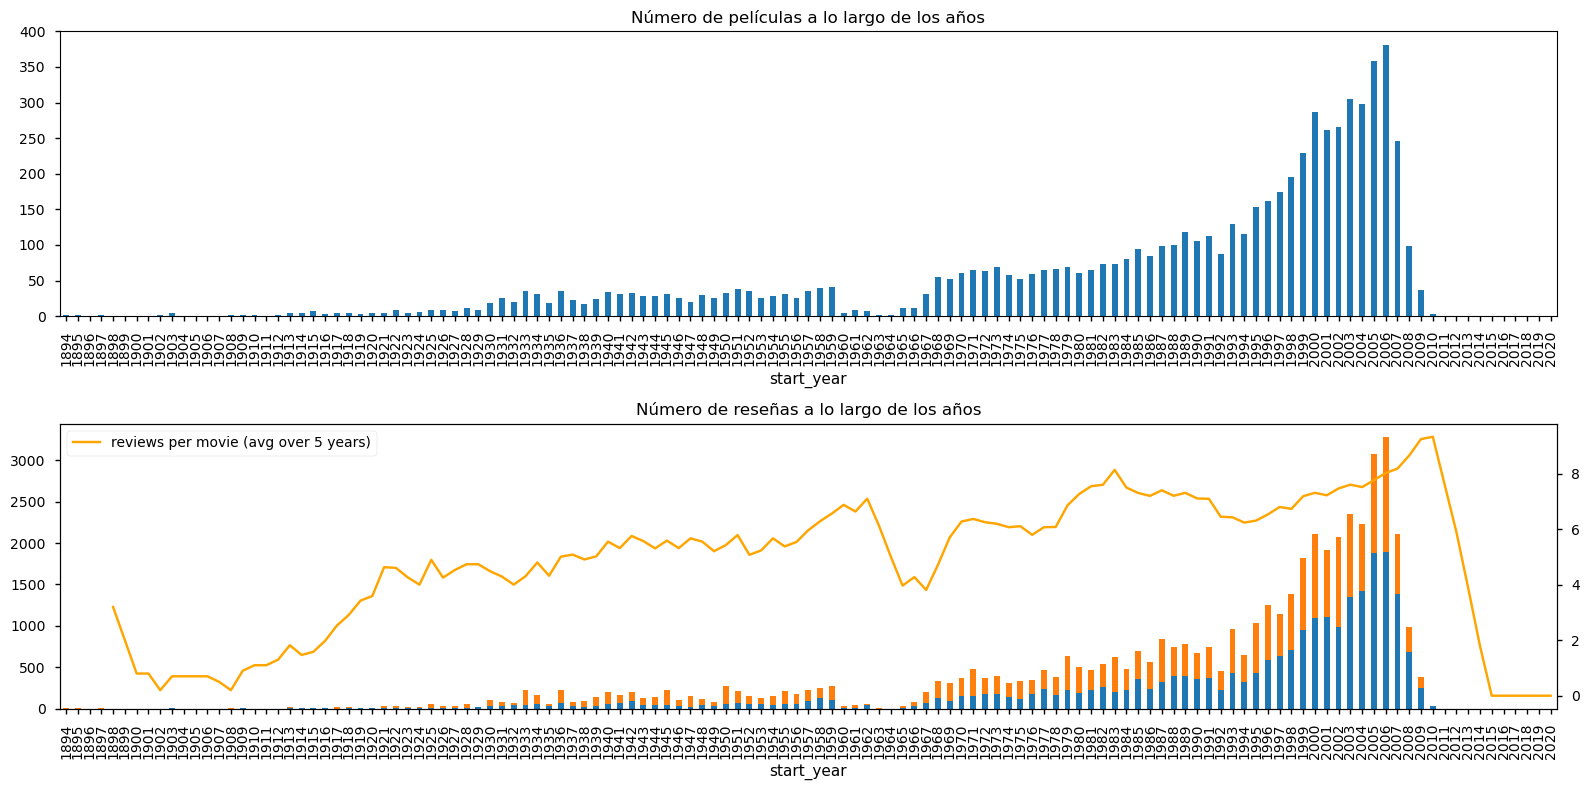

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates(
)['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(
    dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(
    dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(
    dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(
    color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()
plt.show()

### 2.2 Distribución del número de reseñas por película con el conteo exacto y KDE

 (solo para saber cómo puede diferir del conteo exacto)

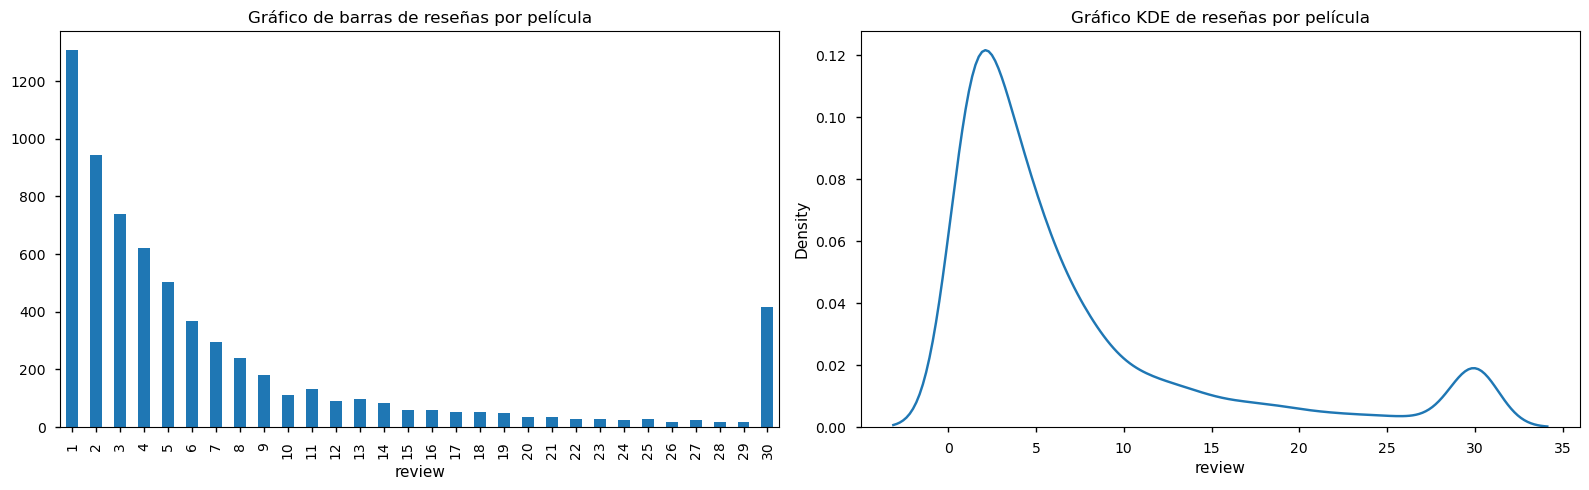

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de reseñas por película')

fig.tight_layout()
plt.show()

### 2.3 Distribución de clases


Distribución de clases (pos):
pos
0    23715
1    23616
Name: count, dtype: int64
pos
0    0.501046
1    0.498954
Name: count, dtype: float64


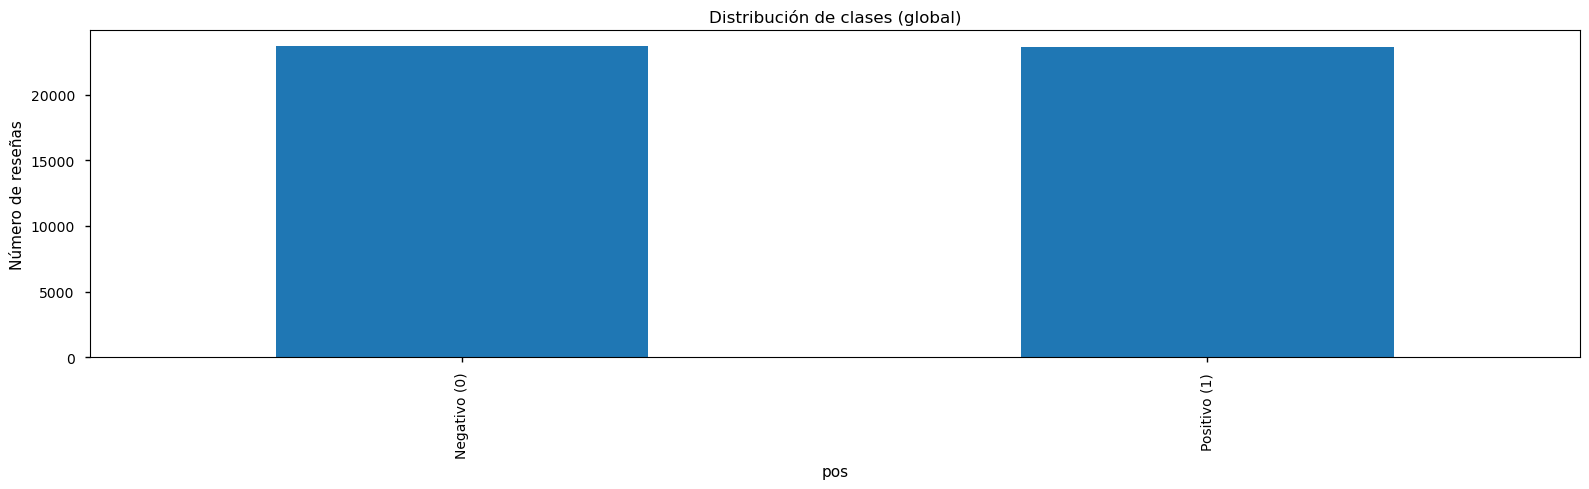

In [8]:
counts = df_reviews['pos'].value_counts().sort_index()
print('\nDistribución de clases (pos):')
print(counts)
print(counts / counts.sum())

plt.figure(figsize=(16, 5))
counts.plot(kind='bar')
plt.xticks([0, 1], ['Negativo (0)', 'Positivo (1)'])
plt.title('Distribución de clases (global)')
plt.ylabel('Número de reseñas')
plt.tight_layout()
plt.show()

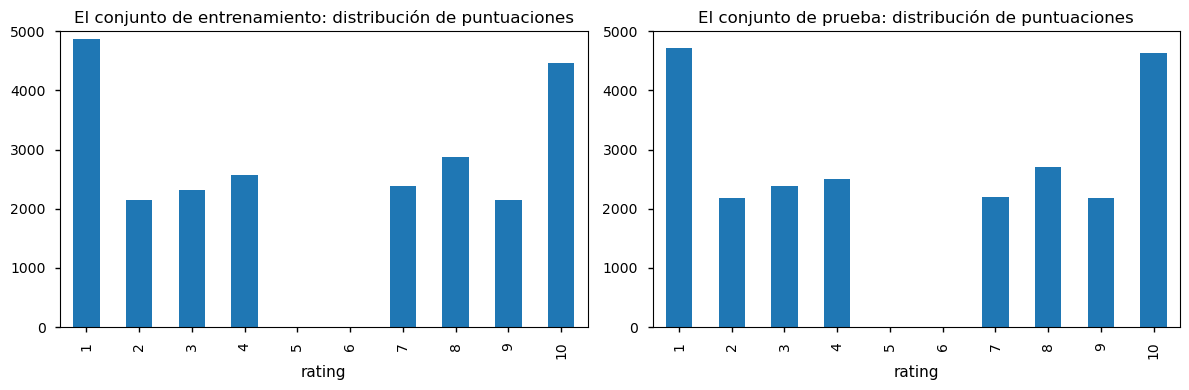

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')[
    'rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1),
                  max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')[
    'rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1),
                  max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()
plt.show()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

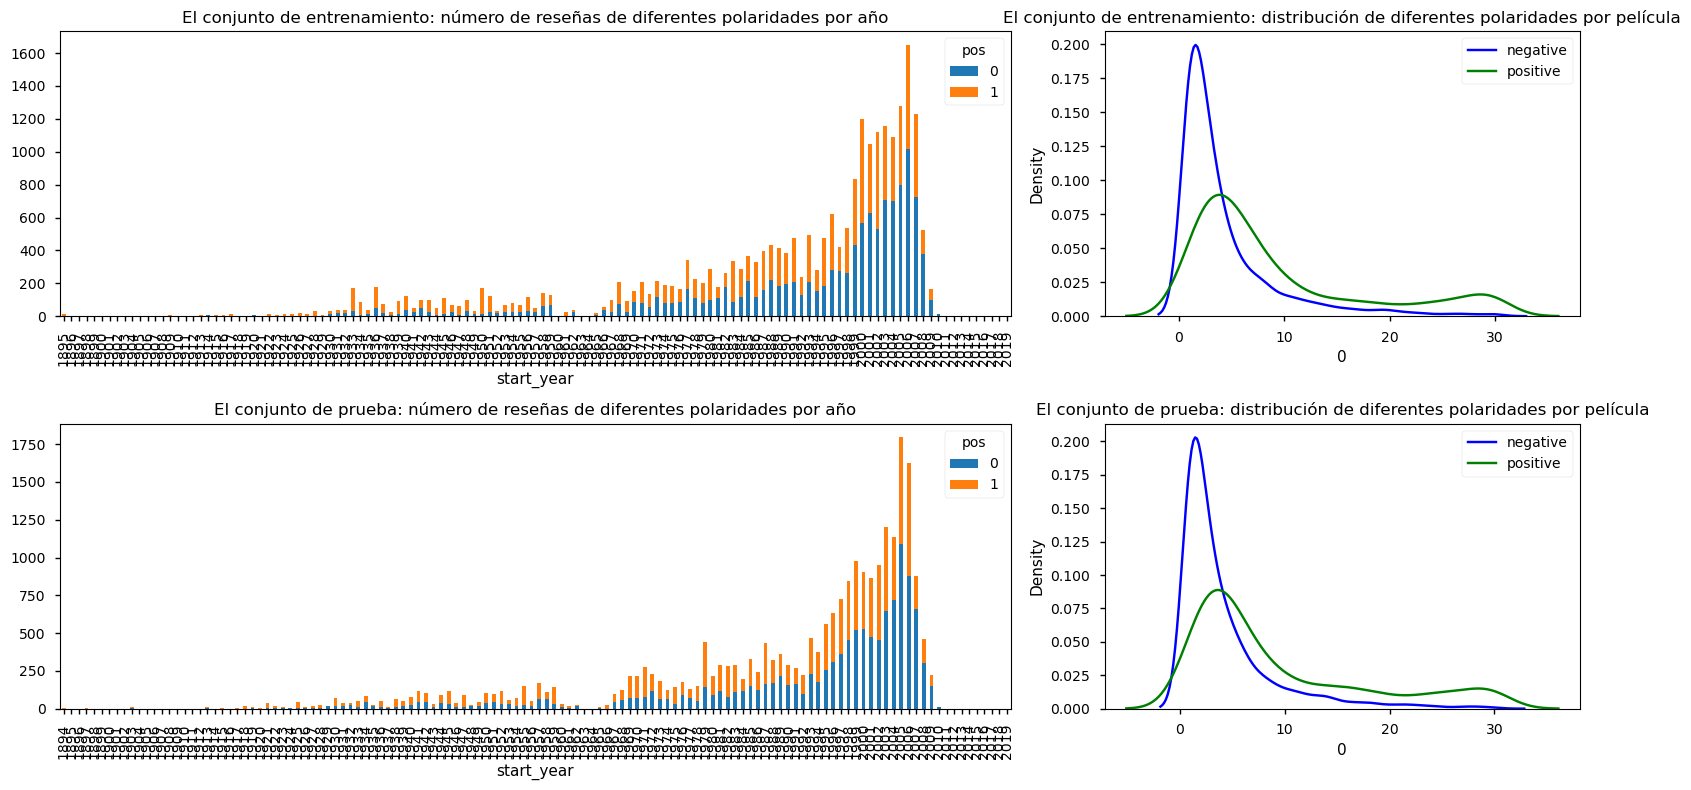

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(
    width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(
    ['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(
    dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title(
    'El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(
    ['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title(
    'El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(
    ['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(
    dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title(
    'El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(
    ['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title(
    'El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()
plt.show()

#### Conclusión del desequilibrio de clases
- La distribución de clases es prácticamente equilibrada.
- La diferencia entre reseñas positivas y negativas es mínima (≈ 0.1%), por lo que no hay un sesgo fuerte hacia ninguna clase.
- Además, las clases entre los datasets de prueba y entrenamiento tienen proporciones muy similares en la distribución de las clases.
- El modelo a entrenar no debería verse afectado por desbalance de clases.

## 3. Procedimiento de evaluación

Rutina de evaluación que se puede usar para todos los modelos en este proyecto

In [11]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold)
                     for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(
            target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color,
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx],
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(
            target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(
        index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)
    plt.show()

    return

## 4. Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
# Función de normalización
def normalize_text(text):
    # Pasar a minúsculas
    text = text.lower()
    # Eliminar dígitos y caracteres no alfabéticos (conservar espacios)
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    # Reemplazar múltiples espacios por uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [13]:
# Aplicar a la columna
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## 5. División en dataset train y test

El conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

features_train = df_reviews_train['review_norm']
features_test = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## 6. Modelos

### 6.0 Modelo Dummy

In [15]:
# DummyClassifier con estrategia 'most_frequent' (predice siempre la clase más frecuente)
model0 = DummyClassifier(strategy='most_frequent', random_state=42)

# Entrenar con los datos de entrenamiento
model0.fit(features_train, target_train)

DummyClassifier(random_state=42, strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


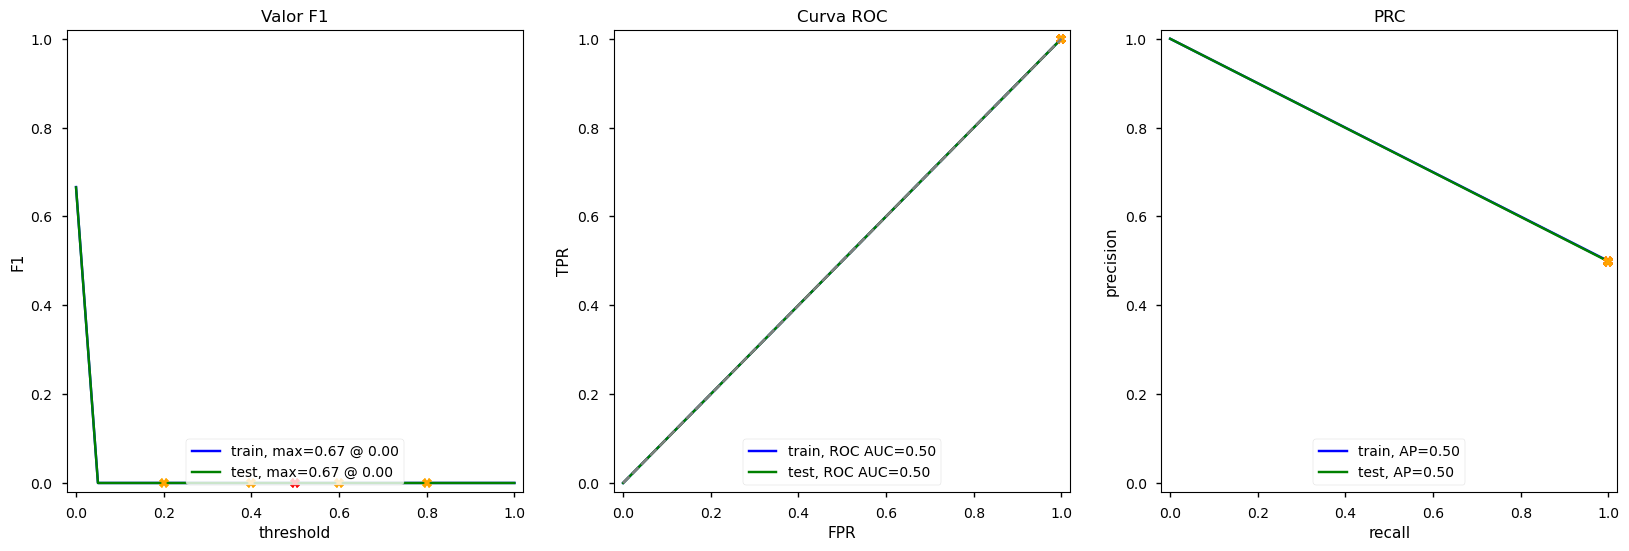

In [16]:
evaluate_model(model0, features_train, target_train,
               features_test, target_test)

### 6.1 NLTK, TF-IDF y LR

In [17]:
# NLTK stopwords
stop_words = list(set(stopwords.words('english')))

# Pipeline con TF-IDF y LR
model1 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=stop_words, max_features=10000)),
    ("clf", LogisticRegression(max_iter=500, random_state=42))
])

# Entrenar
model1.fit(features_train, target_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000,
                                 stop_words=["they're", "she'll", 'about', 's',
                                             'shan', 'why', 'ma', "she's",
                                             'that', 'on', 'myself', 'off',
                                             'further', "isn't", 'any', 'my',
                                             'he', 'too', 'do', 'did', 'than',
                                             "you're", 'she', 'don', 'had', 'o',
                                             "shouldn't", 'for', 'while', 'by', ...])),
                ('clf', LogisticRegression(max_iter=500, random_state=42))])

          train  test
Accuracy   0.92  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


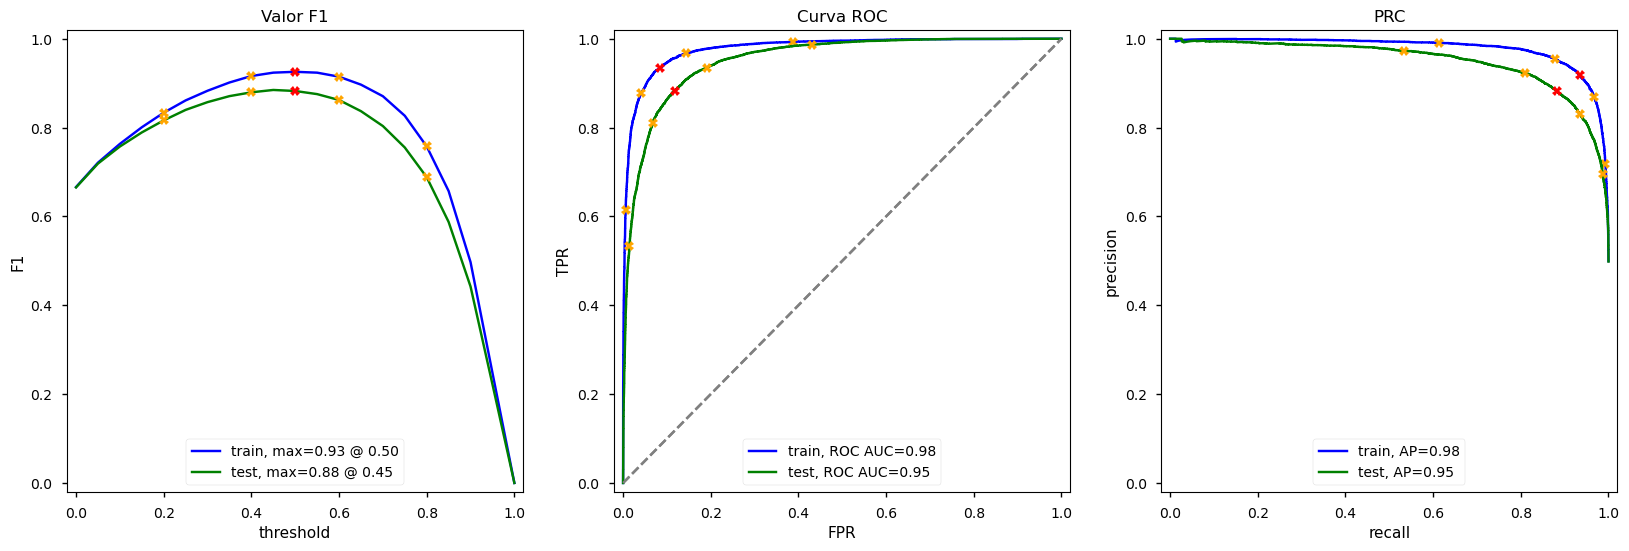

In [18]:
evaluate_model(model1, features_train, target_train,
               features_test, target_test)

### 6.2 SpaCy, TF-IDF y LR

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Tokenizador con spaCy


def spacy_tokenizer(text):
    return [token.text for token in nlp(text)]

In [20]:
model2 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=10000)),
    ('clf', LogisticRegression(max_iter=500, random_state=42))
])

# Entrenar
model2.fit(features_train, target_train)

c:\Users\Samantha\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function spacy_tokenizer at 0x0000024EF2E49080>)),
                ('clf', LogisticRegression(max_iter=500, random_state=42))])

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


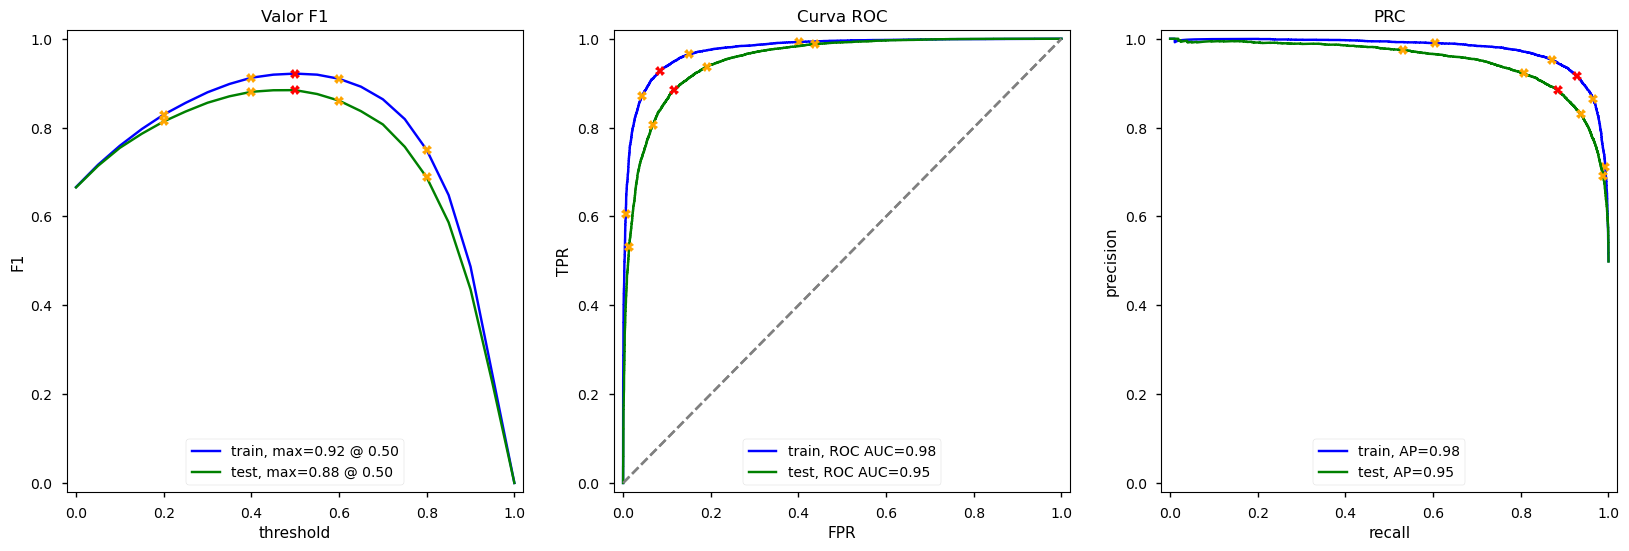

In [21]:
evaluate_model(model2, features_train, target_train,
               features_test, target_test)

### 6.3 spaCy, TF-IDF y LGBMClassifier

In [22]:
model3 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=10000)),
    ('clf', LGBMClassifier(n_estimators=500, random_state=42, verbose=-1))
])

# Entrenar
model3.fit(features_train, target_train)

c:\Users\Samantha\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function spacy_tokenizer at 0x0000024EF2E49080>)),
                ('clf',
                 LGBMClassifier(n_estimators=500, random_state=42,
                                verbose=-1))])

          train  test
Accuracy    1.0  0.88
F1          1.0  0.88
APS         1.0  0.95
ROC AUC     1.0  0.95


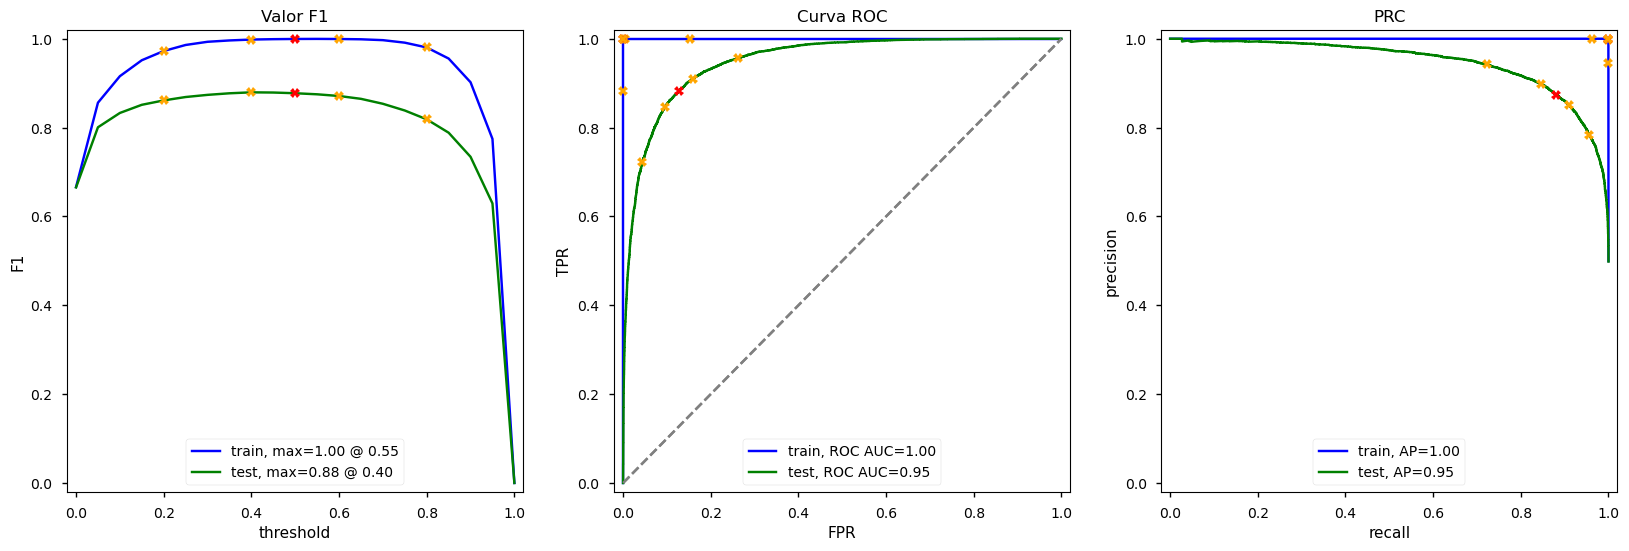

In [23]:
evaluate_model(model3, features_train, target_train,
               features_test, target_test)

## 7. Reseñas

### 7.0 Modelos

In [24]:
models = {
    "NLTK_TFIDF_LR": model1,
    "SpaCy_TFIDF_LR": model2,
    "SpaCy_TFIDF_LGBM": model3
}

### 7.1 Mis reseñas

In [25]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

"\nmy_reviews = pd.DataFrame([\n    'Simplemente no me gustó, no es mi tipo de película.',\n    'Bueno, estaba aburrido y me quedé dormido a media película.',\n    'Estaba realmente fascinada con la película',\n    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',\n    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',\n    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',\n    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',\n    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'\n], columns=['review'])\n"

### 7.2 Normalizar

In [26]:
# Normalizar
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

texts = my_reviews['review_norm']

### 7.3 Predecir

In [27]:
for name, model in models.items():
    preds = model.predict_proba(texts)[:, 1]
    print(f"\nResultados de {name}:")
    for prob, review in zip(preds, texts.str.slice(0, 100)):
        print(f"{prob:.2f}: {review}")


Resultados de NLTK_TFIDF_LR:
0.20: i did not simply like it not my kind of movie
0.16: well i was bored and felt asleep in the middle of the movie
0.59: i was really fascinated with the movie
0.12: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22: i didnt expect the reboot to be so good writers really cared about the source material
0.52: the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90: launching on netflix was a brave move i really appreciate being able to binge on episode after episo

Resultados de SpaCy_TFIDF_LR:
0.17: i did not simply like it not my kind of movie
0.23: well i was bored and felt asleep in the middle of the movie
0.54: i was really fascinated with the movie
0.15: even the actors looked really old and disinterested and they got paid to be in the mov

## Conclusiones

Modelos:
- El modelo Dummy sirve únicamente como línea base, con métricas planas de 0.5 (equivalente al azar) y sin capacidad de discriminación (F1 = 0).
- Todos los modelos superan ampliamente al Dummy, con ROC AUC y APS cercanos a 0.95 en test, lo que indica excelente capacidad de clasificación.
- Los modelos basados en TF-IDF y regresión logística (NLTK y spaCy) ofrecen un rendimiento muy alto, con Accuracy y F1 entre 0.88 y 0.92 en test, mostrando que ambos enfoques de preprocesamiento (NLTK vs. spaCy) son igualmente efectivos.
- El modelo spaCy + TF-IDF + LGBMClassifier logra métricas perfectas en train (overfitting), pero en test se mantiene en el mismo rango (Accuracy y F1 = 0.88), sin mejoras evidentes frente a la regresión logística, lo que sugiere que el aumento de complejidad no aporta beneficios claros.
- Los resultados son prácticamente idénticos en las métricas obtenidas.

Al evaluar las predicciones en las reseñas, notamos:
- NLTK tiende a asignar probabilidades más bajas en casos positivos moderados (ej. "decent flick" → 0.52 vs. spaCy 0.73).
- spaCy otorga scores más altos en reseñas positivas mixtas, lo que podría reflejar una mayor sensibilidad a expresiones de opinión equilibrada.
- Frases claramente negativas como “rotten attempt at a comedy” fueron correctamente detectadas con valores muy bajos.
- Opiniones mixtas como “decent flick” muestran la diferencia de calibración: NLTK (0.52), spaCy (0.73), LGBM (0.89).
- En comentarios claramente positivos (“fascinated with the movie”), los tres modelos coinciden en valores altos (0.54–0.66).

Comportamiento del modelo LGBM:
- El modelo LGBM se sobreajustó (train = 1.0 en todas las métricas).
- En las predicciones de las reseñas, clasifica con más agresividad, elevando scores en casos ambiguos (ej. "not my kind of movie" → 0.62, mientras que en LR rondaba 0.20).